# Example : Intermittency detection in decaying plasma turbulence simulation

For more details about the data, see Ha et al. (2024) [add link here]

## Single aweSOM realization

The dataset used in this example can be found at [Zenodo link]. The example hdf5 file, `features_2j1b1e0r_5000_jasym.h5`, contains the simulation snapshot discussed in the paper [link to paper]. This dataset contains 4 features, $j_{\parallel}$, $j_{\rm asym}$, $b_{\perp}$, and $e_{\parallel}$. Place the hdf5 file in the `examples/plasma-turbulence/` directory and run the script.

To run a single SOM realization, use the `examples/plasma-turbulence/run_plasma_som.py` script with only one value
for each argument.

```bash
cd examples/plasma-turbulence
python run_plasma_som.py --ratio 0.6 --alpha_0 0.1 --train 2097152
```

This will train a SOM realization with an initial learning rate $\alpha_0 = 0.1$, a lattice ratio
$H = 0.6$, and $N = 2097152$ training steps (the entire simulation domain, $L^3 = 128^3$).
Optional toggles inside the script can be modified as needed. `file_name` points to the hdf5 file containing the
simulation snapshot, `sampling_type` can be either "uniform" (random initial weights between -1 and 1) or "sampling" (random initial weights sampled from the data), and `merge_threshold` sets the threshold of cost for merging two cluster centroids.

Two files will be generated: `som_object.*.pkl` and `labels.*.npy`. The former contains the trained SOM object
and the latter contains the cluster IDs for each data point. You can visualize the results following this example 
Jupyter notebook


Load object to analyze

In [1]:
import aweSOM
from aweSOM import Lattice
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

path_to_object = aweSOM.__path__[0] + '/../../examples/plasma-turbulence/'
object_name = 'som_object.fiducial-5000-64-37-0.1-2097152-1u.pkl'

with open(path_to_object + object_name, 'rb') as f:
    map = pickle.load(f)

xdim = map.xdim
ydim = map.ydim

Visualize the U-matrix

Number of centroids: 23


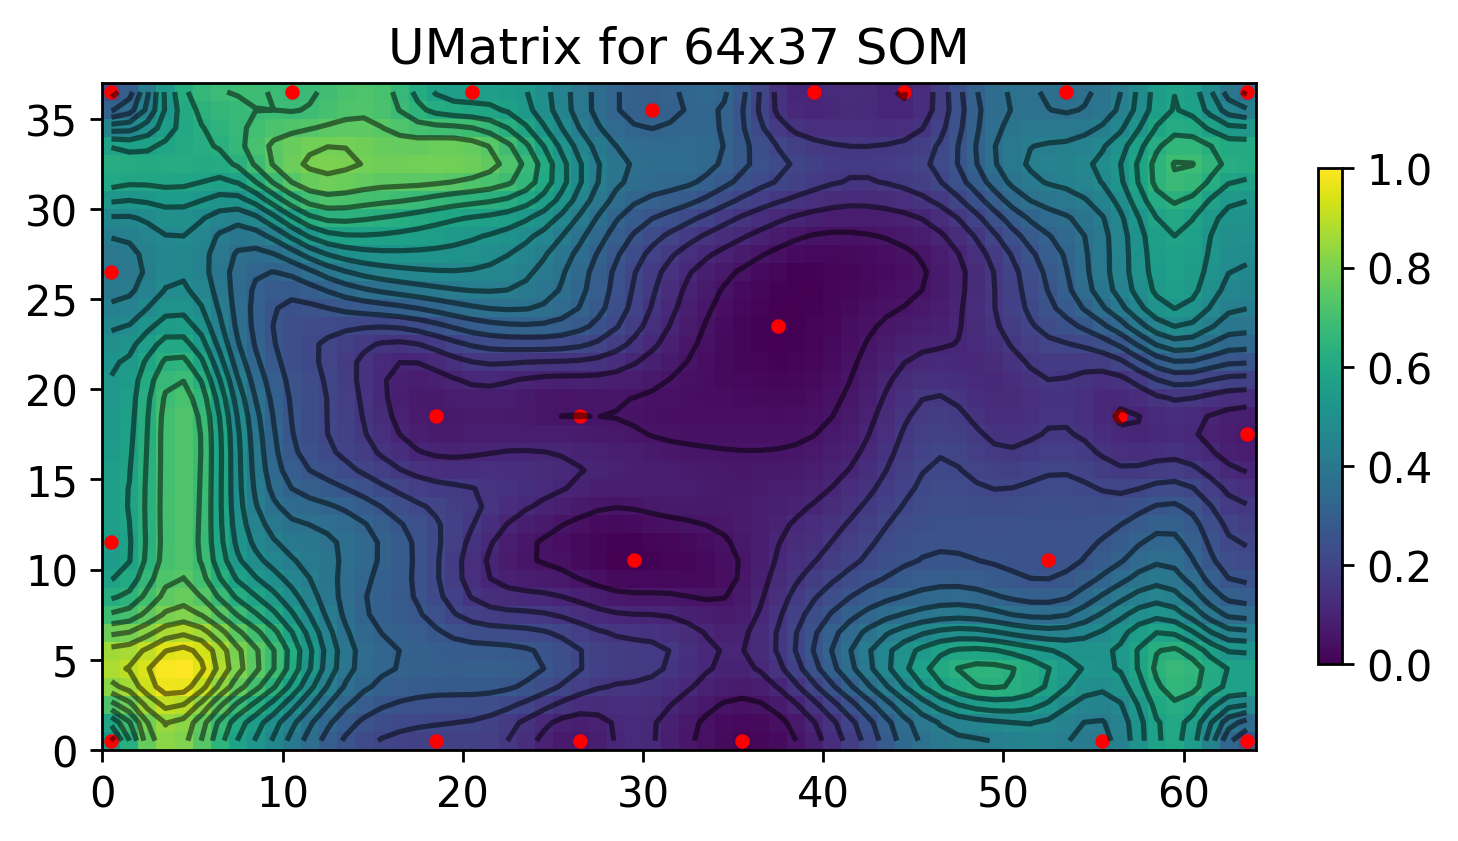

In [2]:
map.umat = map.compute_umat(smoothing=1)
unique_centroids = map.get_unique_centroids(map.compute_centroids())

unique_centroids['position_x'] = [x+0.5 for x in unique_centroids['position_x']]
unique_centroids['position_y'] = [y+0.5 for y in unique_centroids['position_y']]

X,Y = np.meshgrid(np.arange(xdim)+0.5, np.arange(ydim)+0.5)

plt.figure(dpi=250)
plt.pcolormesh(map.umat.T, cmap='viridis')
plt.scatter(unique_centroids['position_x'],unique_centroids['position_y'], color='red', s=10)
plt.colorbar(fraction=0.02)
plt.contour(X, Y, map.umat.T, levels=np.linspace(np.min(map.umat),np.max(map.umat), 20), colors='black', alpha=0.5)
plt.gca().set_aspect("equal")
plt.title(rf'UMatrix for {xdim}x{ydim} SOM')

print('Number of centroids:', len(unique_centroids['position_x']))

U-matrix history

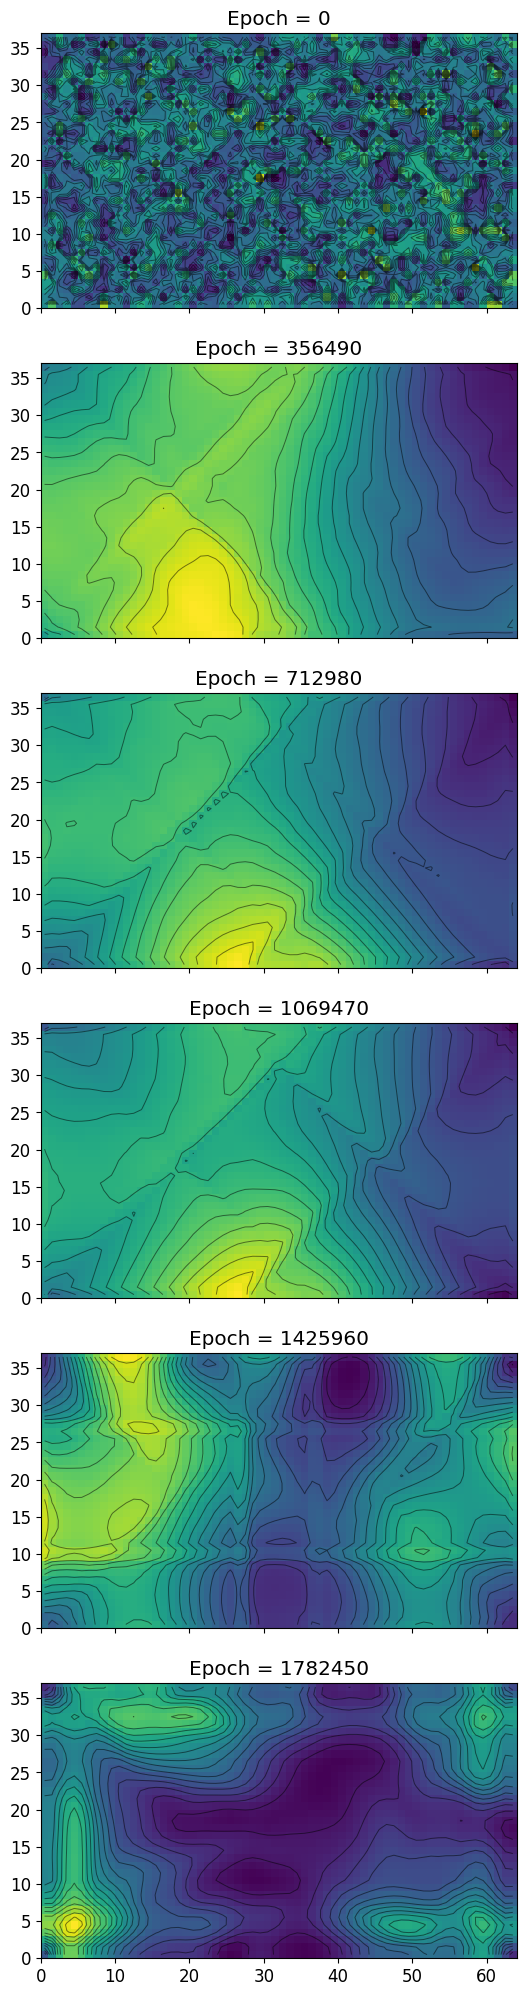

In [3]:
lattice_history = np.array(map.lattice_history)
umat_history = np.array(map.umat_history)
steps = np.linspace(0, lattice_history.shape[0] * map.save_frequency, lattice_history.shape[0], endpoint=False, dtype=int)

xdim = map.xdim
ydim = map.ydim
alpha_0 = map.alpha_0
train = map.train
X,Y = np.meshgrid(np.arange(xdim)+0.5, np.arange(ydim)+0.5)


num_plots = 6
fig, axs = plt.subplots(6, 1, figsize=(10, 25), sharex=True)
fig.subplots_adjust(hspace=0.2)
for i, k in enumerate(range(0, umat_history.shape[0], len(steps)//num_plots+1)):
    umat = umat_history[k]

    axs[i].title.set_text(f'Epoch = {steps[k]}')
    mesh = axs[i].pcolormesh(umat.T, cmap='viridis')
    axs[i].contour(X, Y, umat.T, levels=np.linspace(np.min(umat),np.max(umat), 20), colors='black', alpha=0.5, linewidths=0.7)
    axs[i].set_aspect("equal")


Spider plots to show the relative importance of each feature on the centroids of the identified clusters

In [4]:
plt.rcParams['font.size'] = 18
def plot_centroid_spider(loaded_som_object : Lattice, smoothing : float = None, merge_cost : float = 0.2):
    lattice_values = loaded_som_object.lattice

    # normalize the lattice values around its mean
    lattice_values = np.abs(lattice_values - lattice_values.mean(axis=0))

    mod_lattice_values = np.hstack((lattice_values, lattice_values[:,0].reshape(-1,1)))
    n_features = lattice_values.shape[1]
    features = loaded_som_object.features_names

    dict_lookup = {"j_mag" : r"$j$", "j_par" : r"$j_{\parallel}$", "j_perp" : r"$j_{\perp}$", "j_sym" : r"$j_{\rm s}$", "j_asym" : r"$j_{\rm a}$", "bz" : r"$b_z$", "b_perp" : r"$b_{\perp}$", "e_par" : r"$e_{\parallel}$", "e_perp" : r"$e_{\perp}$"}

    angles = [n / float(n_features) * 2 * np.pi for n in range(n_features)]
    angles += angles[:1]

    loaded_som_object.umat = loaded_som_object.compute_umat(smoothing=smoothing)
    naive_centroids = loaded_som_object.compute_centroids()
    merged_centroids = loaded_som_object.merge_similar_centroids(naive_centroids, threshold=merge_cost)
    unique_centroids = loaded_som_object.get_unique_centroids(merged_centroids)

    unique_centroids_coord = {}

    unique_centroids_coord['position_x'] = [x+0.5 for x in unique_centroids['position_x']]
    unique_centroids_coord['position_y'] = [y+0.5 for y in unique_centroids['position_y']]

    clusters = loaded_som_object.assign_cluster_to_lattice(smoothing=None,merge_cost=merge_cost)
    # numbering_clusters = list(range(len(unique_centroids['position_x'])))

    X,Y = np.meshgrid(np.arange(0,clusters.shape[0],1)+0.5, np.arange(0,clusters.shape[1],1)+0.5)
    dx=10/3
    umat = loaded_som_object.umat

    fig, ax1 = plt.subplots(dpi=300,)
    # ax1.axis('off')
    plt.pcolormesh(clusters.T, cmap='tab10', clim=[0,10], rasterized=True)
    # ax1.pcolormesh(umat.T, cmap='viridis')
    plt.scatter(unique_centroids_coord['position_x'],unique_centroids_coord['position_y'], color='white', s=18)
    # [plt.text(unique_centroids['position_x'][t]+1, unique_centroids['position_y'][t], numbering_clusters[t], color='k', fontsize=10) for t in range(len(numbering_clusters))]
    ax1.contour(X, Y, umat.T, levels=np.linspace(np.min(umat),(np.mean(umat)+np.min(umat))/2, 4), alpha=1, linewidths=0.7, colors='dimgray', linestyles='dotted')
    ax1.contour(X, Y, umat.T, levels=np.linspace((np.mean(umat)+np.min(umat))/2,np.mean(umat), 4), alpha=1, linewidths=0.7, colors='dimgray', linestyles='dashdot')
    ax1.contour(X, Y, umat.T, levels=np.linspace(np.mean(umat),(np.max(umat)+np.mean(umat))/2, 4), alpha=1, linewidths=0.7, colors='dimgray', linestyles='dashed')
    ax1.contour(X, Y, umat.T, levels=np.linspace((np.max(umat)+np.mean(umat))/2,np.max(umat), 4), alpha=1, linewidths=0.7, colors='dimgray', linestyles='solid')
    ax1.set_aspect("equal")
    ax1.set_title(f'{loaded_som_object.xdim}-{loaded_som_object.ydim}-{loaded_som_object.alpha_0}-{loaded_som_object.train} SOM')
    # ax1.set_xticks(np.arange(0, 128, 30), np.arange(0, 128*dx, 30*dx, dtype=int))
    # ax1.set_yticks(np.arange(0, 128, 30), np.arange(0, 128*dx, 30*dx, dtype=int))
    ax1.set_xlabel('X (node)')
    ax1.set_ylabel('Y (node)')

    for centroid_id in range(len(unique_centroids['position_x'])):
        row_values_of_centroids = [loaded_som_object.rowix(unique_centroids['position_x'][centroid_id], unique_centroids['position_y'][centroid_id])]
        
        # nrow = 2
        ncol = 3
        pos_x = [0.07, 0.37, 0.67]
        pos_y = [-0.25, -0.65, -1.05, -1.45, -1.85, -2.25]
        # pos_x = [1.1, 1.4, 1.7]
        # pos_y = [0.8, 0.3]
        position_of_subplot = pos_x[centroid_id % ncol], pos_y[centroid_id // ncol], 0.25, 0.25
        if centroid_id == 6:
            position_of_subplot = 0.3, 0.4, 0.25, 0.25
        ax2 = fig.add_axes(position_of_subplot, polar=True)
        ax2.set_xticks(angles[:-1], [dict_lookup[feature] for feature in features], color='black', size=17)
        ax2.set_rlabel_position(0)
        ax2.set_yticks([0, 0.6, 1.2], ["0", "0.6", "1.2"], color="dimgray", size=5)
        ax2.set_ylim(0.0,mod_lattice_values.max())
        # ax2.set_yscale('log')
        ax2.plot(angles, mod_lattice_values[row_values_of_centroids[0]], linewidth=1.5, linestyle='solid', color='black')
        ax2.fill(angles, mod_lattice_values[row_values_of_centroids[0]], 'k', alpha=0.3)
        ax2.set_facecolor(f'C{centroid_id}')
    
    plt.show()

Centroid A: (np.int64(39), np.int64(26)), count: 190
Centroid B: (np.int64(37), np.int64(23)), count: 376
Merging...
Centroid A: (np.int64(44), np.int64(35)), count: 40
Centroid B: (np.int64(39), np.int64(35)), count: 39
Merging...
Centroid A: (np.int64(25), np.int64(19)), count: 47
Centroid B: (np.int64(18), np.int64(18)), count: 400
Merging...
Centroid A: (np.int64(56), np.int64(18)), count: 100
Centroid B: (np.int64(63), np.int64(17)), count: 133
Merging...
Centroid A: (np.int64(35), np.int64(0)), count: 97
Centroid B: (np.int64(26), np.int64(0)), count: 55
Merging...
Centroid A: (np.int64(29), np.int64(10)), count: 259
Centroid B: (np.int64(35), np.int64(0)), count: 152
Merging...
Centroid A: (np.int64(49), np.int64(20)), count: 92
Centroid B: (np.int64(37), np.int64(23)), count: 566
Merging...
Centroid A: (np.int64(29), np.int64(10)), count: 411
Centroid B: (np.int64(37), np.int64(23)), count: 658
Merging...
Centroid A: (np.int64(44), np.int64(35)), count: 79
Centroid B: (np.int64

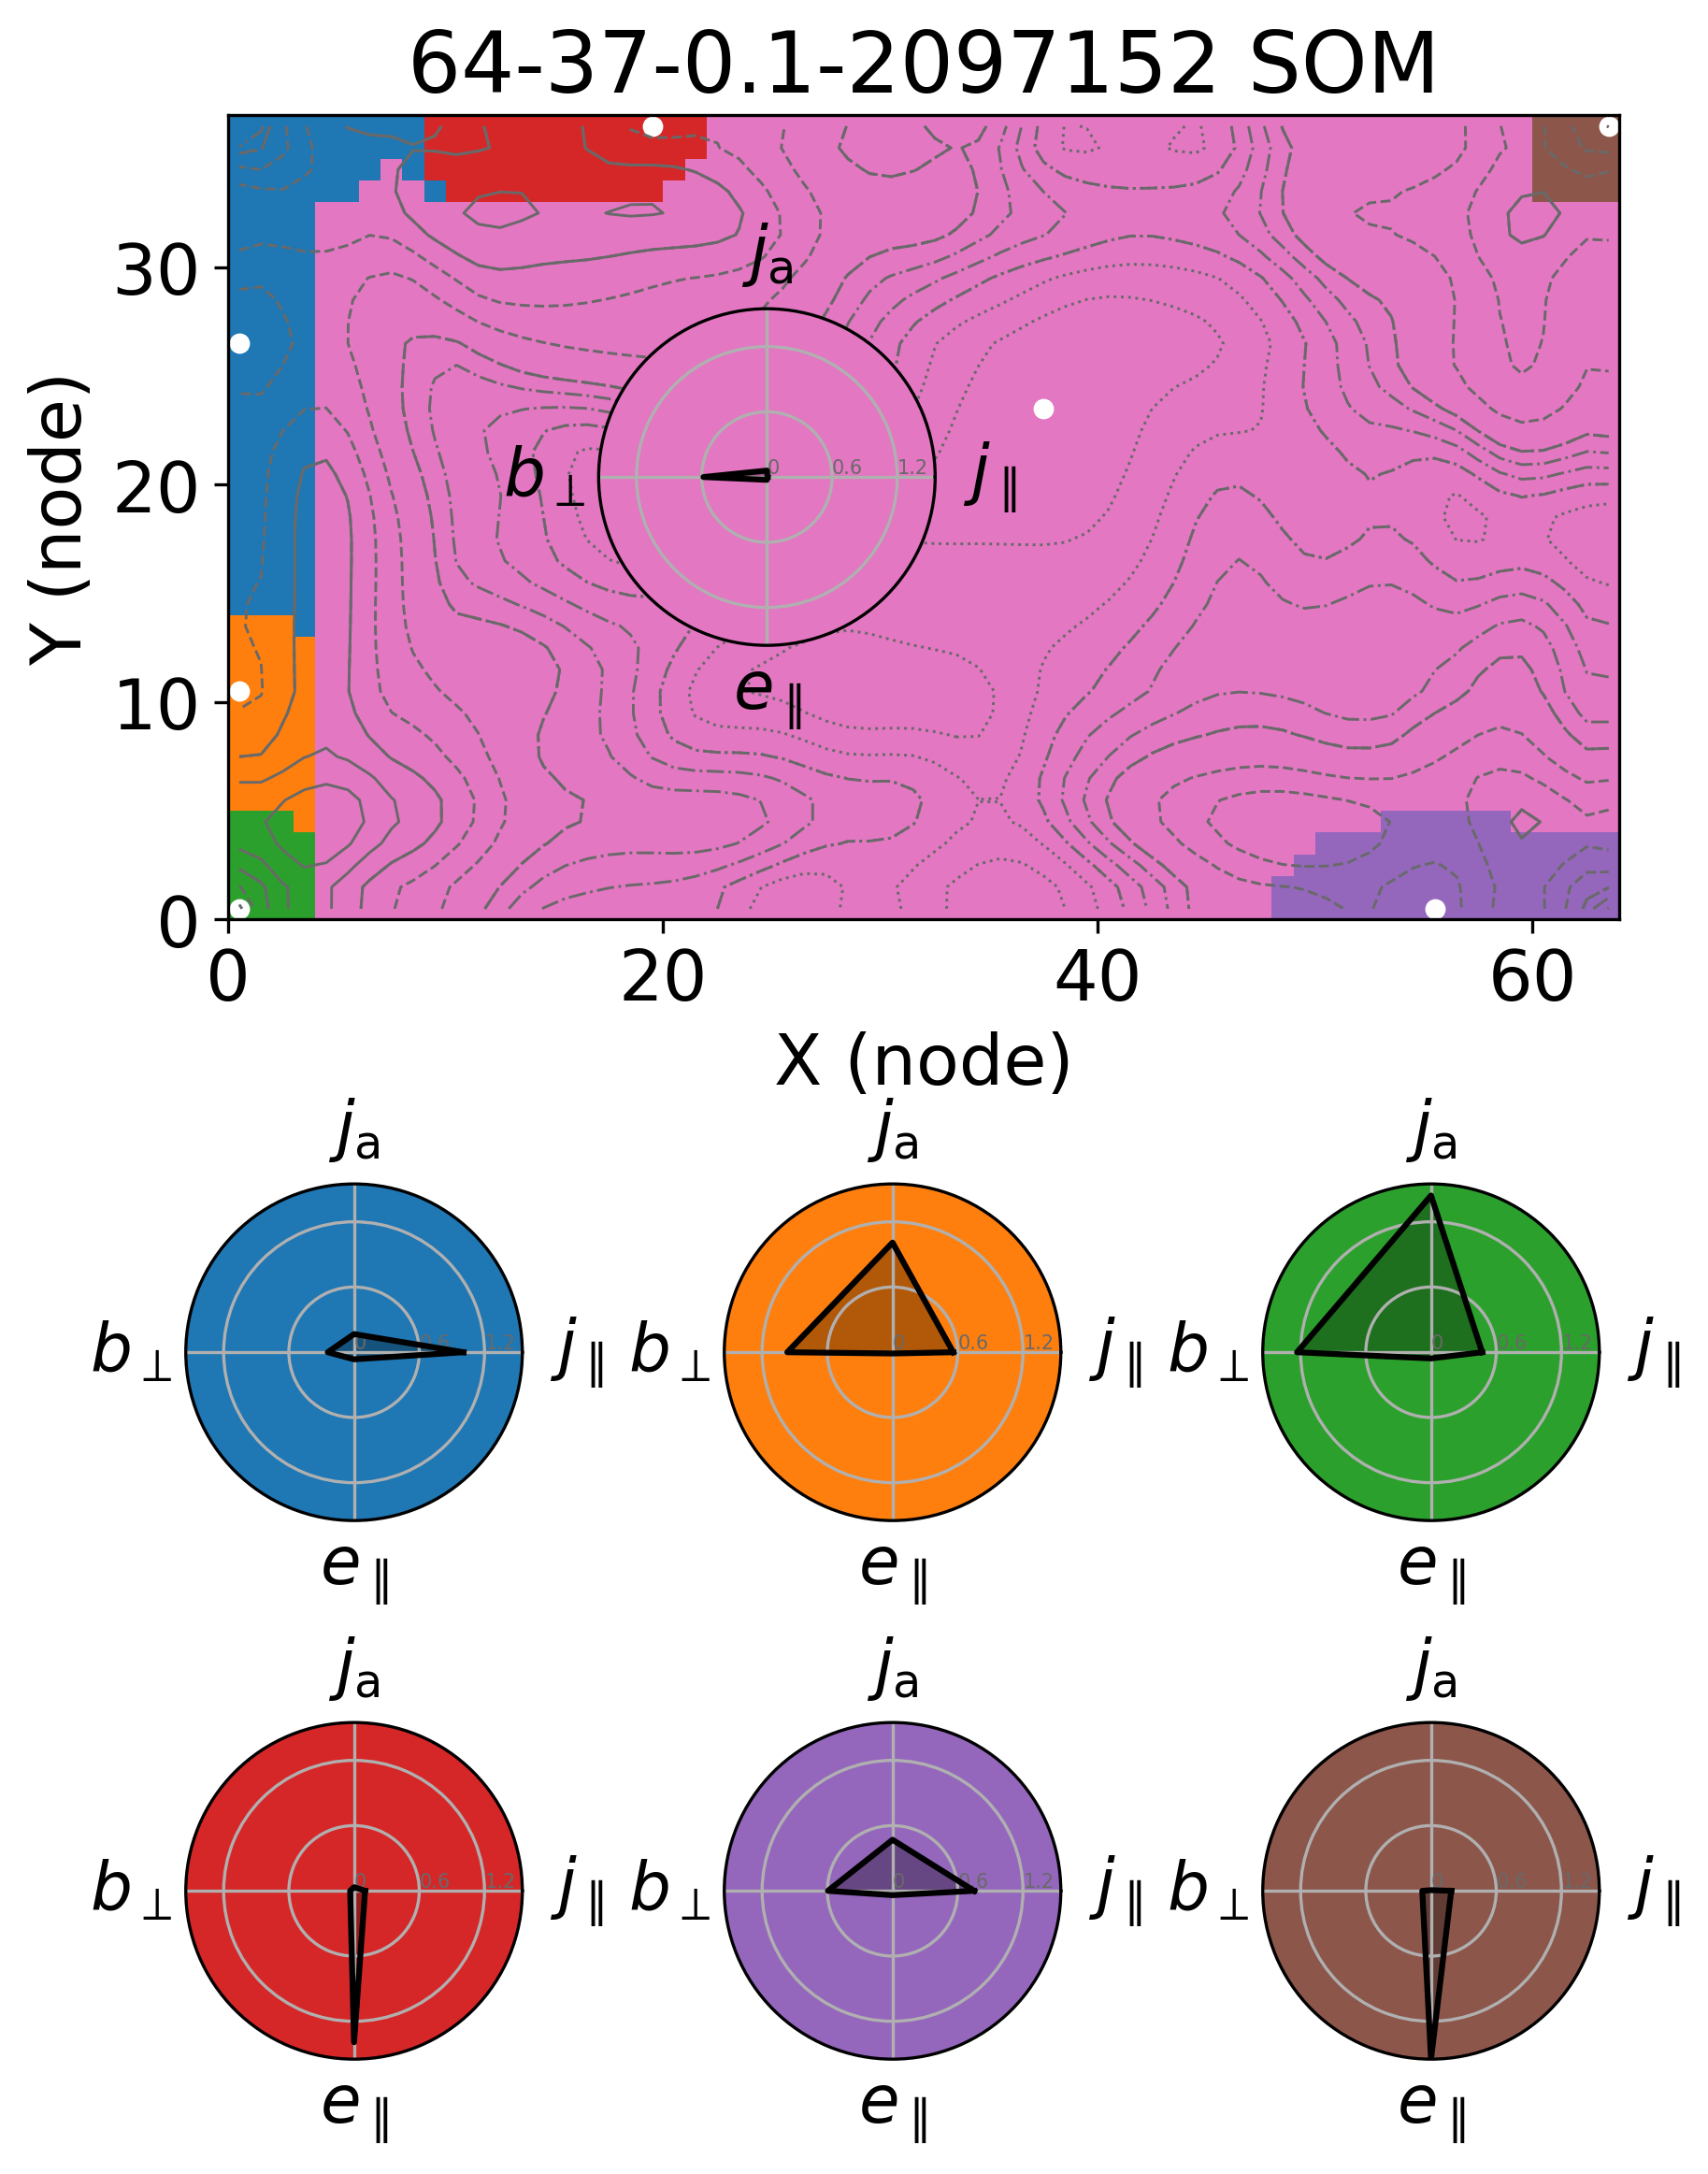

In [5]:
merge_cost = 0.25
smoothing = None # a number or None (cannot be 0)
plot_centroid_spider(map, smoothing=smoothing, merge_cost=merge_cost)

Map SOM result to data

In [6]:
final_clusters = map.assign_cluster_to_lattice(smoothing=smoothing, merge_cost=merge_cost)
som_labels = map.assign_cluster_to_data(map.projection_2d, final_clusters)

Centroid A: (np.int64(39), np.int64(26)), count: 190
Centroid B: (np.int64(37), np.int64(23)), count: 376
Merging...
Centroid A: (np.int64(44), np.int64(35)), count: 40
Centroid B: (np.int64(39), np.int64(35)), count: 39
Merging...


Centroid A: (np.int64(25), np.int64(19)), count: 47
Centroid B: (np.int64(18), np.int64(18)), count: 400
Merging...
Centroid A: (np.int64(56), np.int64(18)), count: 100
Centroid B: (np.int64(63), np.int64(17)), count: 133
Merging...
Centroid A: (np.int64(35), np.int64(0)), count: 97
Centroid B: (np.int64(26), np.int64(0)), count: 55
Merging...
Centroid A: (np.int64(29), np.int64(10)), count: 259
Centroid B: (np.int64(35), np.int64(0)), count: 152
Merging...
Centroid A: (np.int64(49), np.int64(20)), count: 92
Centroid B: (np.int64(37), np.int64(23)), count: 566
Merging...
Centroid A: (np.int64(29), np.int64(10)), count: 411
Centroid B: (np.int64(37), np.int64(23)), count: 658
Merging...
Centroid A: (np.int64(44), np.int64(35)), count: 79
Centroid B: (np.int64(37), np.int64(23)), count: 1069
Merging...
Centroid A: (np.int64(18), np.int64(18)), count: 447
Centroid B: (np.int64(37), np.int64(23)), count: 1148
Merging...
Centroid A: (np.int64(48), np.int64(0)), count: 12
Centroid B: (np.int

Load simulation data to compare

You need a few things here. First is the original hdf5 snapshot of the simulation, `d3x128s10/flds_5000.h5`, second is the configuration file to read the snapshot, `d3x128s10.ini`. 

Download the files from [link to zenodo archive], then provide the path to the files with `path`.

In [7]:
original_path = os.getcwd()
print('Current working directory:', original_path)

Current working directory: /mnt/home/tha10/git_repos/aweSOM/examples/plasma-turbulence


In [8]:
import read_turbulence_data as rtd
conf = "d3x128s10.ini"
path = '/mnt/home/tha10/ceph/sim_snapshots/'# "/Users/tvh0021/Documents/Archive/"
filename = "flds_5000.h5"
lap = 5000

decay_turb = rtd.GetH5Data(path, filename, conf, lap)
# get the data
dx = 10./3.
decay_turb.return_basic_j_fields(dx)
decay_turb.return_all_other_fields()

d3x128s10
plotting j_par
flds


/mnt/home/tha10/git_repos/aweSOM/examples/plasma-turbulence/initialize_turbulence.py:175: RuntimeWarning: divide by zero encountered in scalar divide
  A = 0.1 * self.g0 / self.gammarad**2  # definition we use in Runko


Visualize the SOM result vs. a xy-slice of the $j_{\parallel}$.

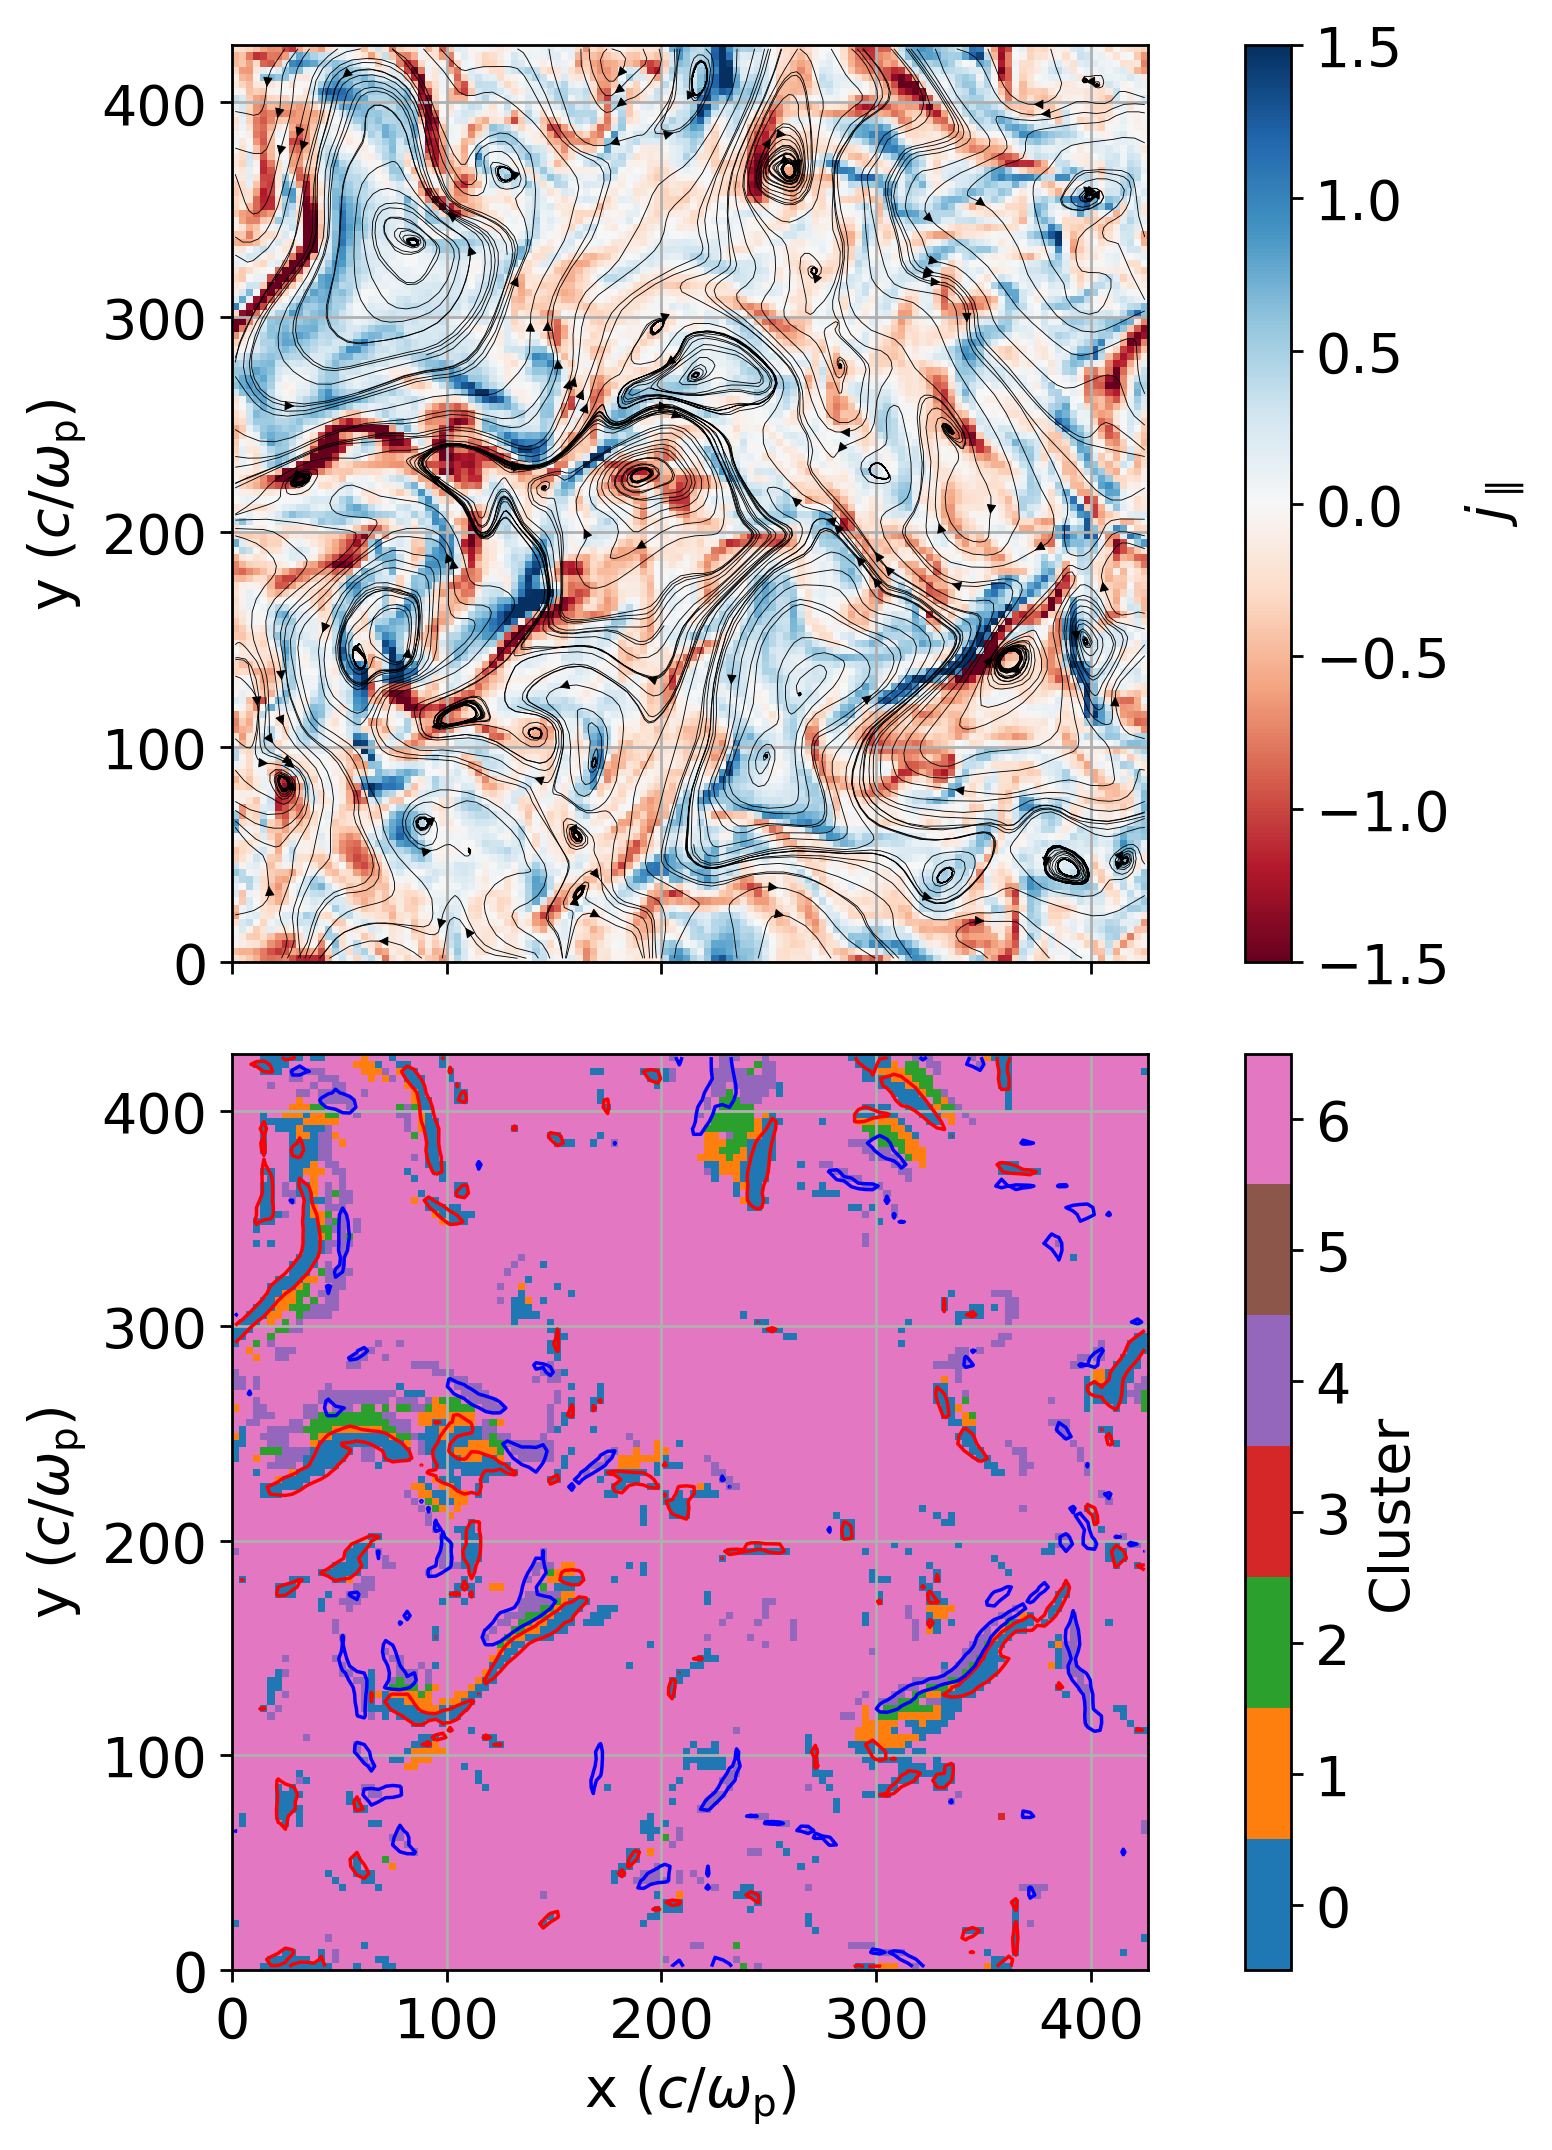

In [9]:
bx = decay_turb.bx
by = decay_turb.by
j_par = decay_turb.j_par
j_par_rms = np.sqrt(np.mean(j_par**2))
nx, ny, nz = decay_turb.nx, decay_turb.ny, decay_turb.nz
som_labels_transformed = som_labels.reshape((nz, ny, nx))

plt.rcParams.update({'font.size': 16})

slice_numbers = [27]

for slice_number in slice_numbers:
    fig, ax = plt.subplots(2, 1, figsize=(10, 10), dpi=250, sharex=True)
    fig.subplots_adjust(hspace=0.1)

    jmag_plot = ax[0].pcolormesh(j_par[slice_number], cmap='RdBu', clim=[-1.5,1.5], rasterized=True)
    fig.colorbar(jmag_plot, ax=ax[0], fraction=0.042, pad=0.05, label=r'$j_{\parallel}$', ticks=[-1.5, -1, -0.5, 0, 0.5, 1, 1.5], location="right")
    # ax[0].contour(np.arange(0, nx)+0.5, np.arange(0, ny)+0.5, j_par[slice_number,:,:], levels=[-2.*j_par_rms,2.*j_par_rms], colors='green', linewidths=1, linestyles='solid')
    ax[0].streamplot(np.arange(0, nx)+0.5, np.arange(0, ny)+0.5, bx[slice_number], by[slice_number], color='black', linewidth=0.25, broken_streamlines=False, density=1., integration_direction='both', arrowstyle='-|>', arrowsize=0.6, )
    # fig.colorbar(eperp_plot, ax=ax[0], fraction=0.042, pad=0.04, label=r'$E_{\perp}$', ticks=[0, 0.1, 0.2, 0.3])
    ax[0].set_aspect('equal', adjustable='box')
    ax[0].grid()
    # ax[0].set_xticks(np.arange(0, 128, 30), np.arange(0, 128*dx, 30*dx, dtype=int))
    ax[0].set_yticks(np.arange(0, 128, 30), np.arange(0, 128*dx, 30*dx, dtype=int))
    # ax[0].set_xlabel(r'x ($c/\omega_p$)')
    ax[0].set_ylabel(r'y ($c/\omega_{\rm p}$)')
    # ax[0].set_title(f'z = {slice_number*dx:.0f} '+ r'$c/\omega_{\rm p}$')

    cluster_plot = ax[1].pcolormesh(som_labels_transformed[slice_number], cmap='tab10', clim=[0,10], rasterized=True)
    cbar = fig.colorbar(cluster_plot, ax=ax[1], fraction=0.042, pad=0.05, label='Cluster', ticks=np.arange(0, len(set(som_labels)))+0.5, boundaries=np.arange(0, len(set(som_labels))+1), location="right")
    cbar.ax.set_yticklabels(np.arange(0, len(set(som_labels))))
    ax[1].contour(np.arange(0, nx)+0.5, np.arange(0, ny)+0.5, j_par[slice_number,:,:], levels=[-2.*j_par_rms,2.*j_par_rms], colors=['red','blue'], linewidths=1, linestyles='solid')
    # ax[1].streamplot(np.arange(0, nx)+0.5, np.arange(0, ny)+0.5, bx[slice_number], by[slice_number], color='black', linewidth=0.25, broken_streamlines=False, density=1, integration_direction='both', arrowstyle='-|>', arrowsize=0.6, )
    ax[1].set_aspect('equal', adjustable='box')
    ax[1].grid()
    ax[1].set_xticks(np.arange(0, 128, 30), np.arange(0, 128*dx, 30*dx, dtype=int))
    ax[1].set_yticks(np.arange(0, 128, 30), np.arange(0, 128*dx, 30*dx, dtype=int))
    ax[1].set_xlabel(r'x ($c/\omega_{\rm p}$)')
    ax[1].set_ylabel(r'y ($c/\omega_{\rm p}$)')

    plt.show()

## Stacking multiple aweSOM realizations for SCE analysis

To run a set of SOM realizations, use the `examples/plasma-turbulence/run_plasma_som.py` script with multiple values for each argument.

```bash
cd examples/plasma-turbulence
python run_plasma_som.py --ratio 0.6 0.8 1. --alpha_0 0.1 0.2 0.4 --train 1000000 2097152 4194304
```

A set of pre-trained aweSOM realizations can be retrieved [here](link_to_Zenodo). Alternatively you can try your own parameters.


In [ ]:
original_path = os.getcwd()
print('Current working directory:', original_path)

Current working directory: /mnt/home/tha10/git_repos/aweSOM/examples/plasma-turbulence


In [ ]:
import read_turbulence_data as rtd
conf = "d3x128s10.ini"
path = '/mnt/home/tha10/ceph/sim_snapshots/'# "/Users/tvh0021/Documents/Archive/"
filename = "flds_5000.h5"
lap = 5000

decay_turb = rtd.GetH5Data(path, filename, conf, lap)
# get the data
dx = 10./3.
decay_turb.return_basic_j_fields(dx)
decay_turb.return_all_other_fields()

d3x128s10
plotting j_par
flds


/mnt/home/tha10/git_repos/aweSOM/examples/plasma-turbulence/initialize_turbulence.py:175: RuntimeWarning: divide by zero encountered in scalar divide
  A = 0.1 * self.g0 / self.gammarad**2  # definition we use in Runko


Refer to `examples/slurm_scripts/submit_plasma.slurm` for an example of the command to run the parameter scan on a set of aweSOM realizations.

You will need the file `features_2j1b1e0r_5000_jasym.h5` from [link to file]. You can also generate different sets of features using the `examples/plasma-turbulence/obtain_features.py` file.

`examples/plasma-turbulence/run_plasma_som.py` will run multiple aweSOM realizations, using the `multiprocessing` package, so the more cores available, the faster it should run.

The result of this run is a list of files with names `labels.*` and `som_object.*`. The labels are final clustering results, while the objects are pickle files of the entire trained lattice that can be modified.

To run the SCE clustering, import `cuda` to use GPU acceleration. GPU is not necessary for the Iris dataset but is absolutely necessary here ($N_{\rm iris} = 150$, $N_{\rm plasma} = 128^3$).

Run the SCE $G_{\rm sum}$ calculation with `python3 [path_to_aweSOM]/aweSOM/src/aweSOM/sce.py --subfolder SCE --dims 2097152`. Make sure that the first line of output is ``Using JAX for GPU computation``

Using one NVIDIA V-100 GPU, this should not take more than 3 minutes to complete. All cluster masks and `multimap_mappings.txt` are saved in `SCE/`

Now visualize $G_{\rm sum}$

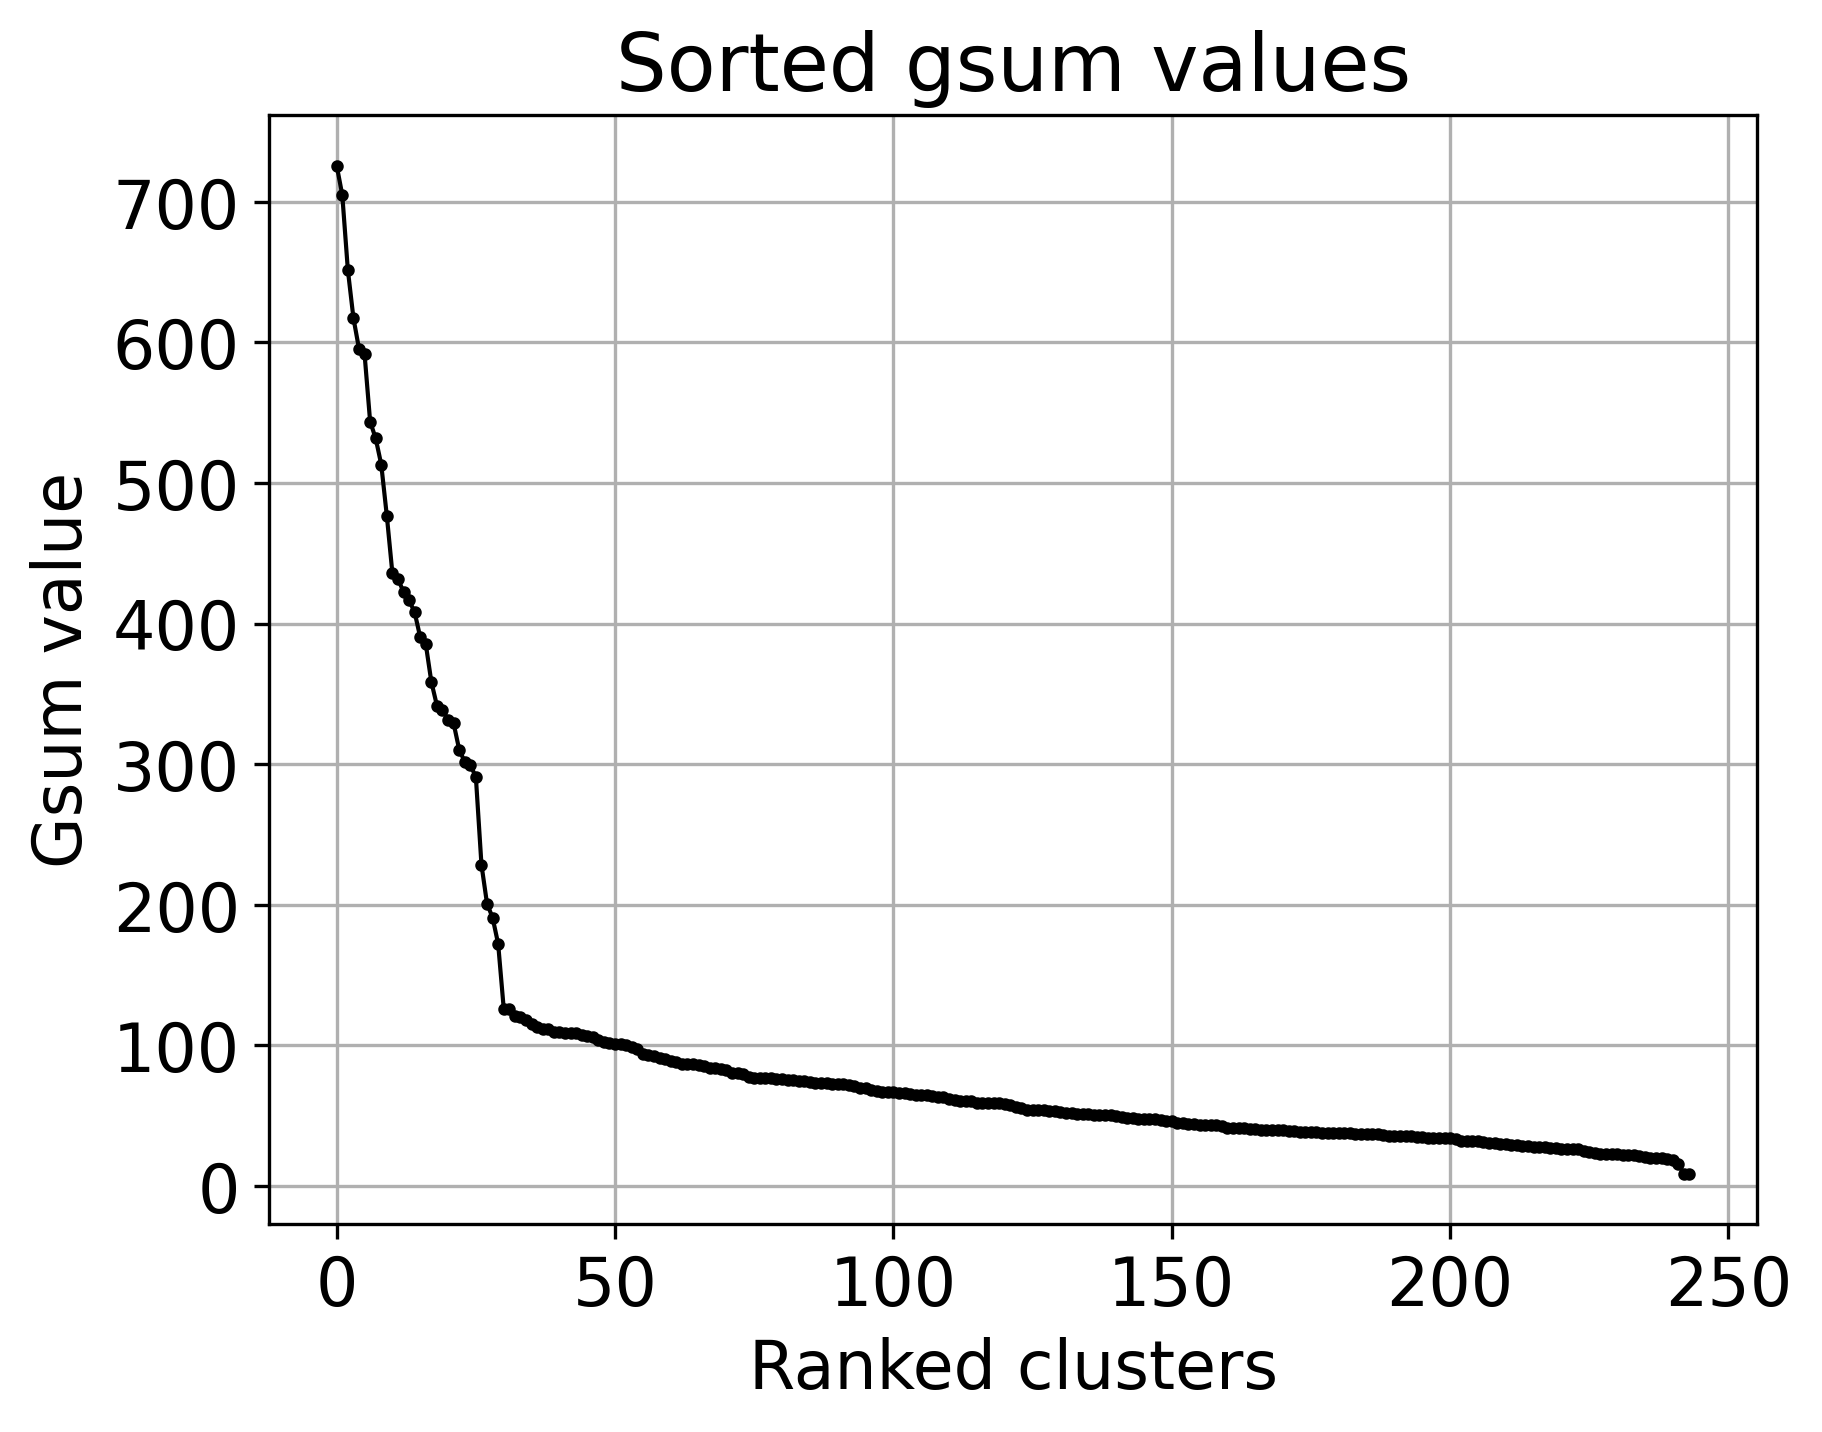

In [ ]:
os.chdir(original_path) # recover the original path

file_path = 'som_results/SCE/'
file_name = 'multimap_mappings.txt'

from aweSOM.make_sce_clusters import get_gsum_values, plot_gsum_values

ranked_gsum_list, map_list = get_gsum_values(file_path+file_name)

plot_gsum_values(ranked_gsum_list)

In the simplest case, add all gsum values together to obtain final SCE clustering result

In [ ]:
number_of_points = int(128**3)

sce_sum = np.zeros((number_of_points))

for i in range(len(ranked_gsum_list)):
    current_cluster_mask = np.load(f"{file_path}/mask-{map_list[i][2]}-id{map_list[i][1]}.npy")
    sce_sum += current_cluster_mask

Visualize the SCE stacking result

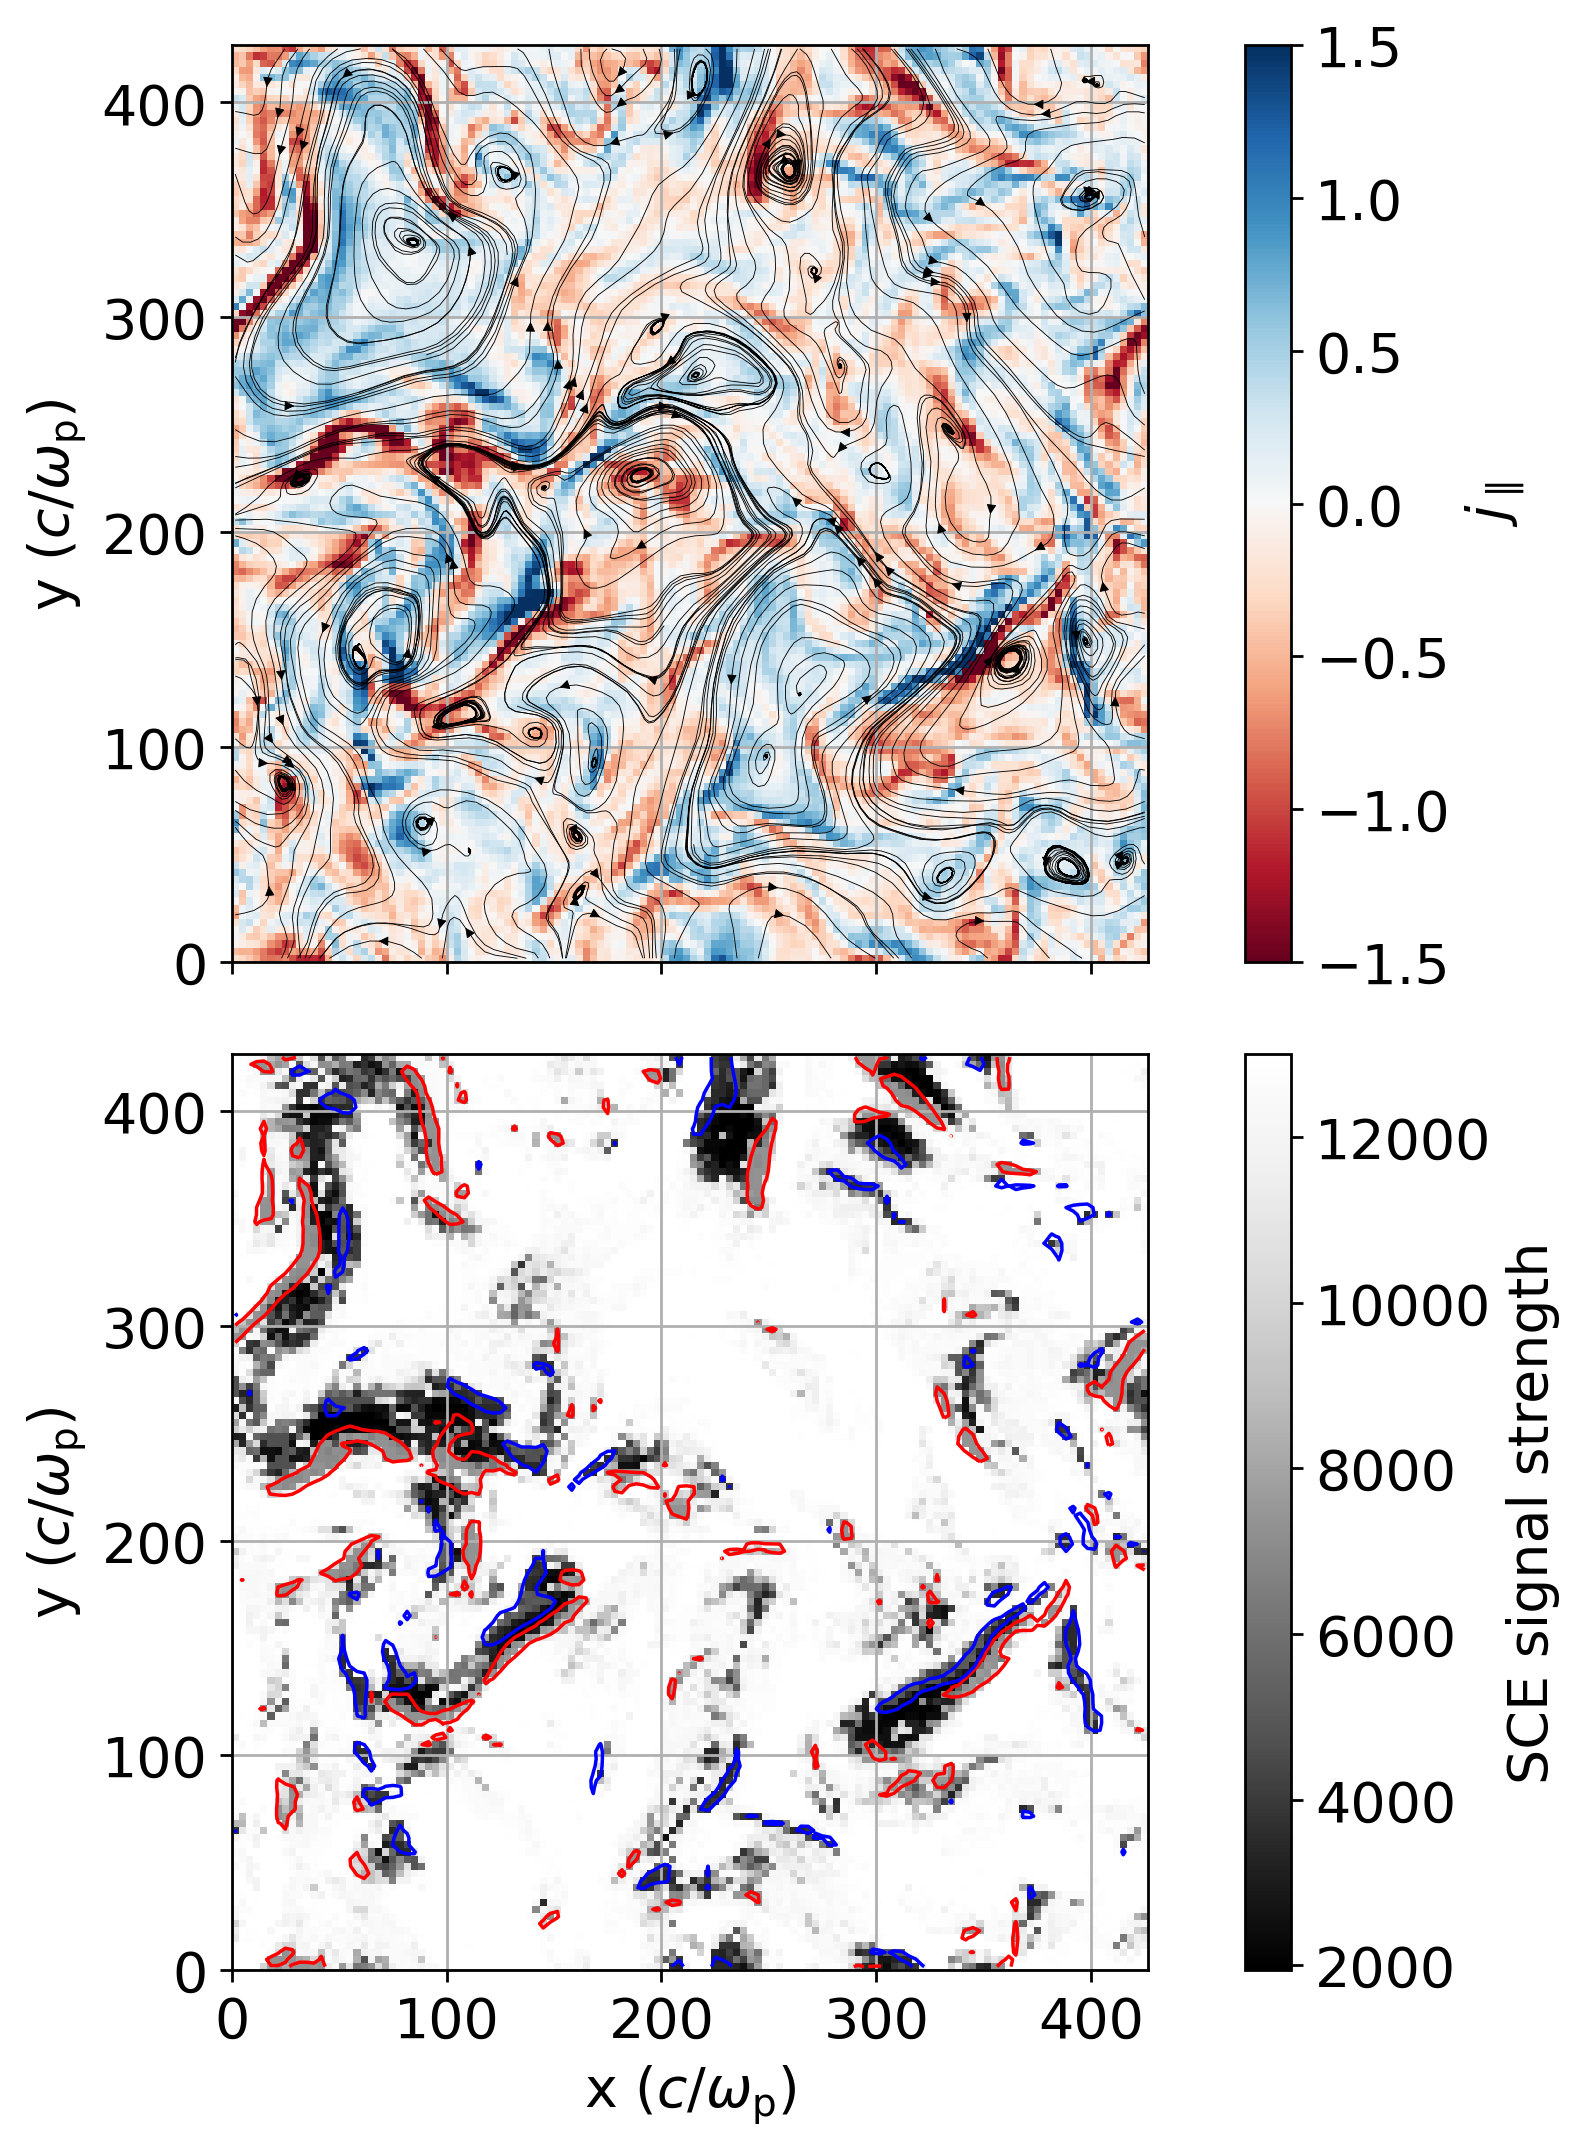

In [ ]:
sce_sum_transformed = sce_sum.reshape((128,128,128))

slice_numbers = [27]

for slice_number in slice_numbers:
    fig, ax = plt.subplots(2, 1, figsize=(10, 10), dpi=250, sharex=True)
    fig.subplots_adjust(hspace=0.1)

    jmag_plot = ax[0].pcolormesh(j_par[slice_number], cmap='RdBu', clim=[-1.5,1.5], rasterized=True)
    fig.colorbar(jmag_plot, ax=ax[0], fraction=0.042, pad=0.05, label=r'$j_{\parallel}$', ticks=[-1.5, -1, -0.5, 0, 0.5, 1, 1.5], location="right")
    # ax[0].contour(np.arange(0, nx)+0.5, np.arange(0, ny)+0.5, j_par[slice_number,:,:], levels=[-2.*j_par_rms,2.*j_par_rms], colors='green', linewidths=1, linestyles='solid')
    ax[0].streamplot(np.arange(0, nx)+0.5, np.arange(0, ny)+0.5, bx[slice_number], by[slice_number], color='black', linewidth=0.25, broken_streamlines=False, density=1., integration_direction='both', arrowstyle='-|>', arrowsize=0.6, )
    # fig.colorbar(eperp_plot, ax=ax[0], fraction=0.042, pad=0.04, label=r'$E_{\perp}$', ticks=[0, 0.1, 0.2, 0.3])
    ax[0].set_aspect('equal', adjustable='box')
    ax[0].grid()
    # ax[0].set_xticks(np.arange(0, 128, 30), np.arange(0, 128*dx, 30*dx, dtype=int))
    ax[0].set_yticks(np.arange(0, 128, 30), np.arange(0, 128*dx, 30*dx, dtype=int))
    # ax[0].set_xlabel(r'x ($c/\omega_p$)')
    ax[0].set_ylabel(r'y ($c/\omega_{\rm p}$)')
    # ax[0].set_title(f'z = {slice_number*dx:.0f} '+ r'$c/\omega_{\rm p}$')

    cluster_plot = ax[1].pcolormesh(sce_sum_transformed[slice_number], cmap='Greys_r', rasterized=True)
    cbar = fig.colorbar(cluster_plot, ax=ax[1], fraction=0.042, pad=0.05, label='SCE signal strength', location="right")
    # cbar.ax.set_yticklabels(np.arange(0, len(set(som_labels))))
    ax[1].contour(np.arange(0, nx)+0.5, np.arange(0, ny)+0.5, j_par[slice_number,:,:], levels=[-2.*j_par_rms,2.*j_par_rms], colors=['red','blue'], linewidths=1, linestyles='solid')
    # ax[1].streamplot(np.arange(0, nx)+0.5, np.arange(0, ny)+0.5, bx[slice_number], by[slice_number], color='black', linewidth=0.25, broken_streamlines=False, density=1, integration_direction='both', arrowstyle='-|>', arrowsize=0.6, )
    ax[1].set_aspect('equal', adjustable='box')
    ax[1].grid()
    ax[1].set_xticks(np.arange(0, 128, 30), np.arange(0, 128*dx, 30*dx, dtype=int))
    ax[1].set_yticks(np.arange(0, 128, 30), np.arange(0, 128*dx, 30*dx, dtype=int))
    ax[1].set_xlabel(r'x ($c/\omega_{\rm p}$)')
    ax[1].set_ylabel(r'y ($c/\omega_{\rm p}$)')

    plt.show()

Let's visualize the distribution of these SCE signal strengths

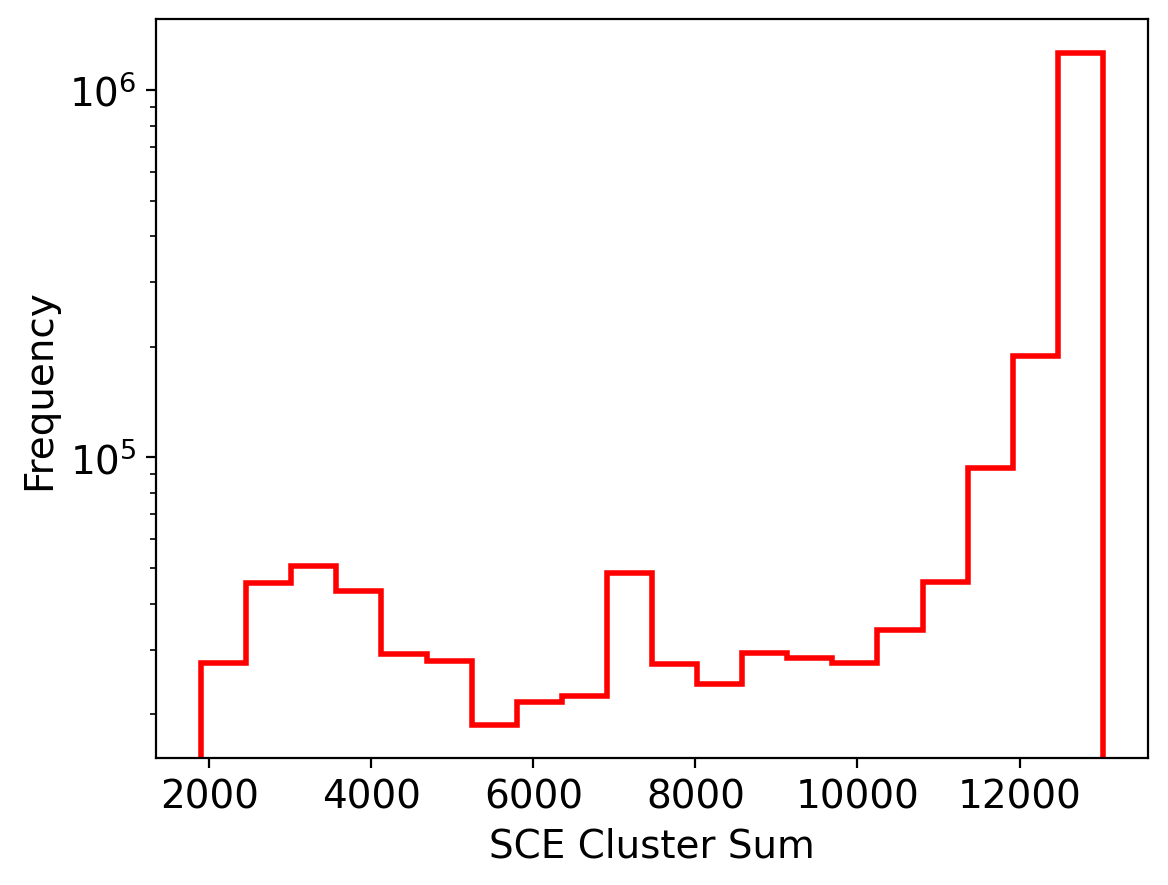

In [ ]:
plt.rcParams.update({'font.size': 14})
plt.figure(dpi=200)
plt.hist(sce_sum, bins=20, color='r', label='SCE Cluster Sum', histtype='step', linewidth=2)
plt.xlabel('SCE Cluster Sum')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

Set a cutoff

In [ ]:
signal_cutoff = [3500, 6000, 10000]

sce_clusters = np.zeros(number_of_points, dtype=int)
for i in range(len(sce_sum)):
    if sce_sum[i] < signal_cutoff[0]:
        sce_clusters[i] = 0
    elif sce_sum[i] < signal_cutoff[1]:
        sce_clusters[i] = 1
    elif sce_sum[i] < signal_cutoff[2]:
        sce_clusters[i] = 2
    else:
        sce_clusters[i] = 3

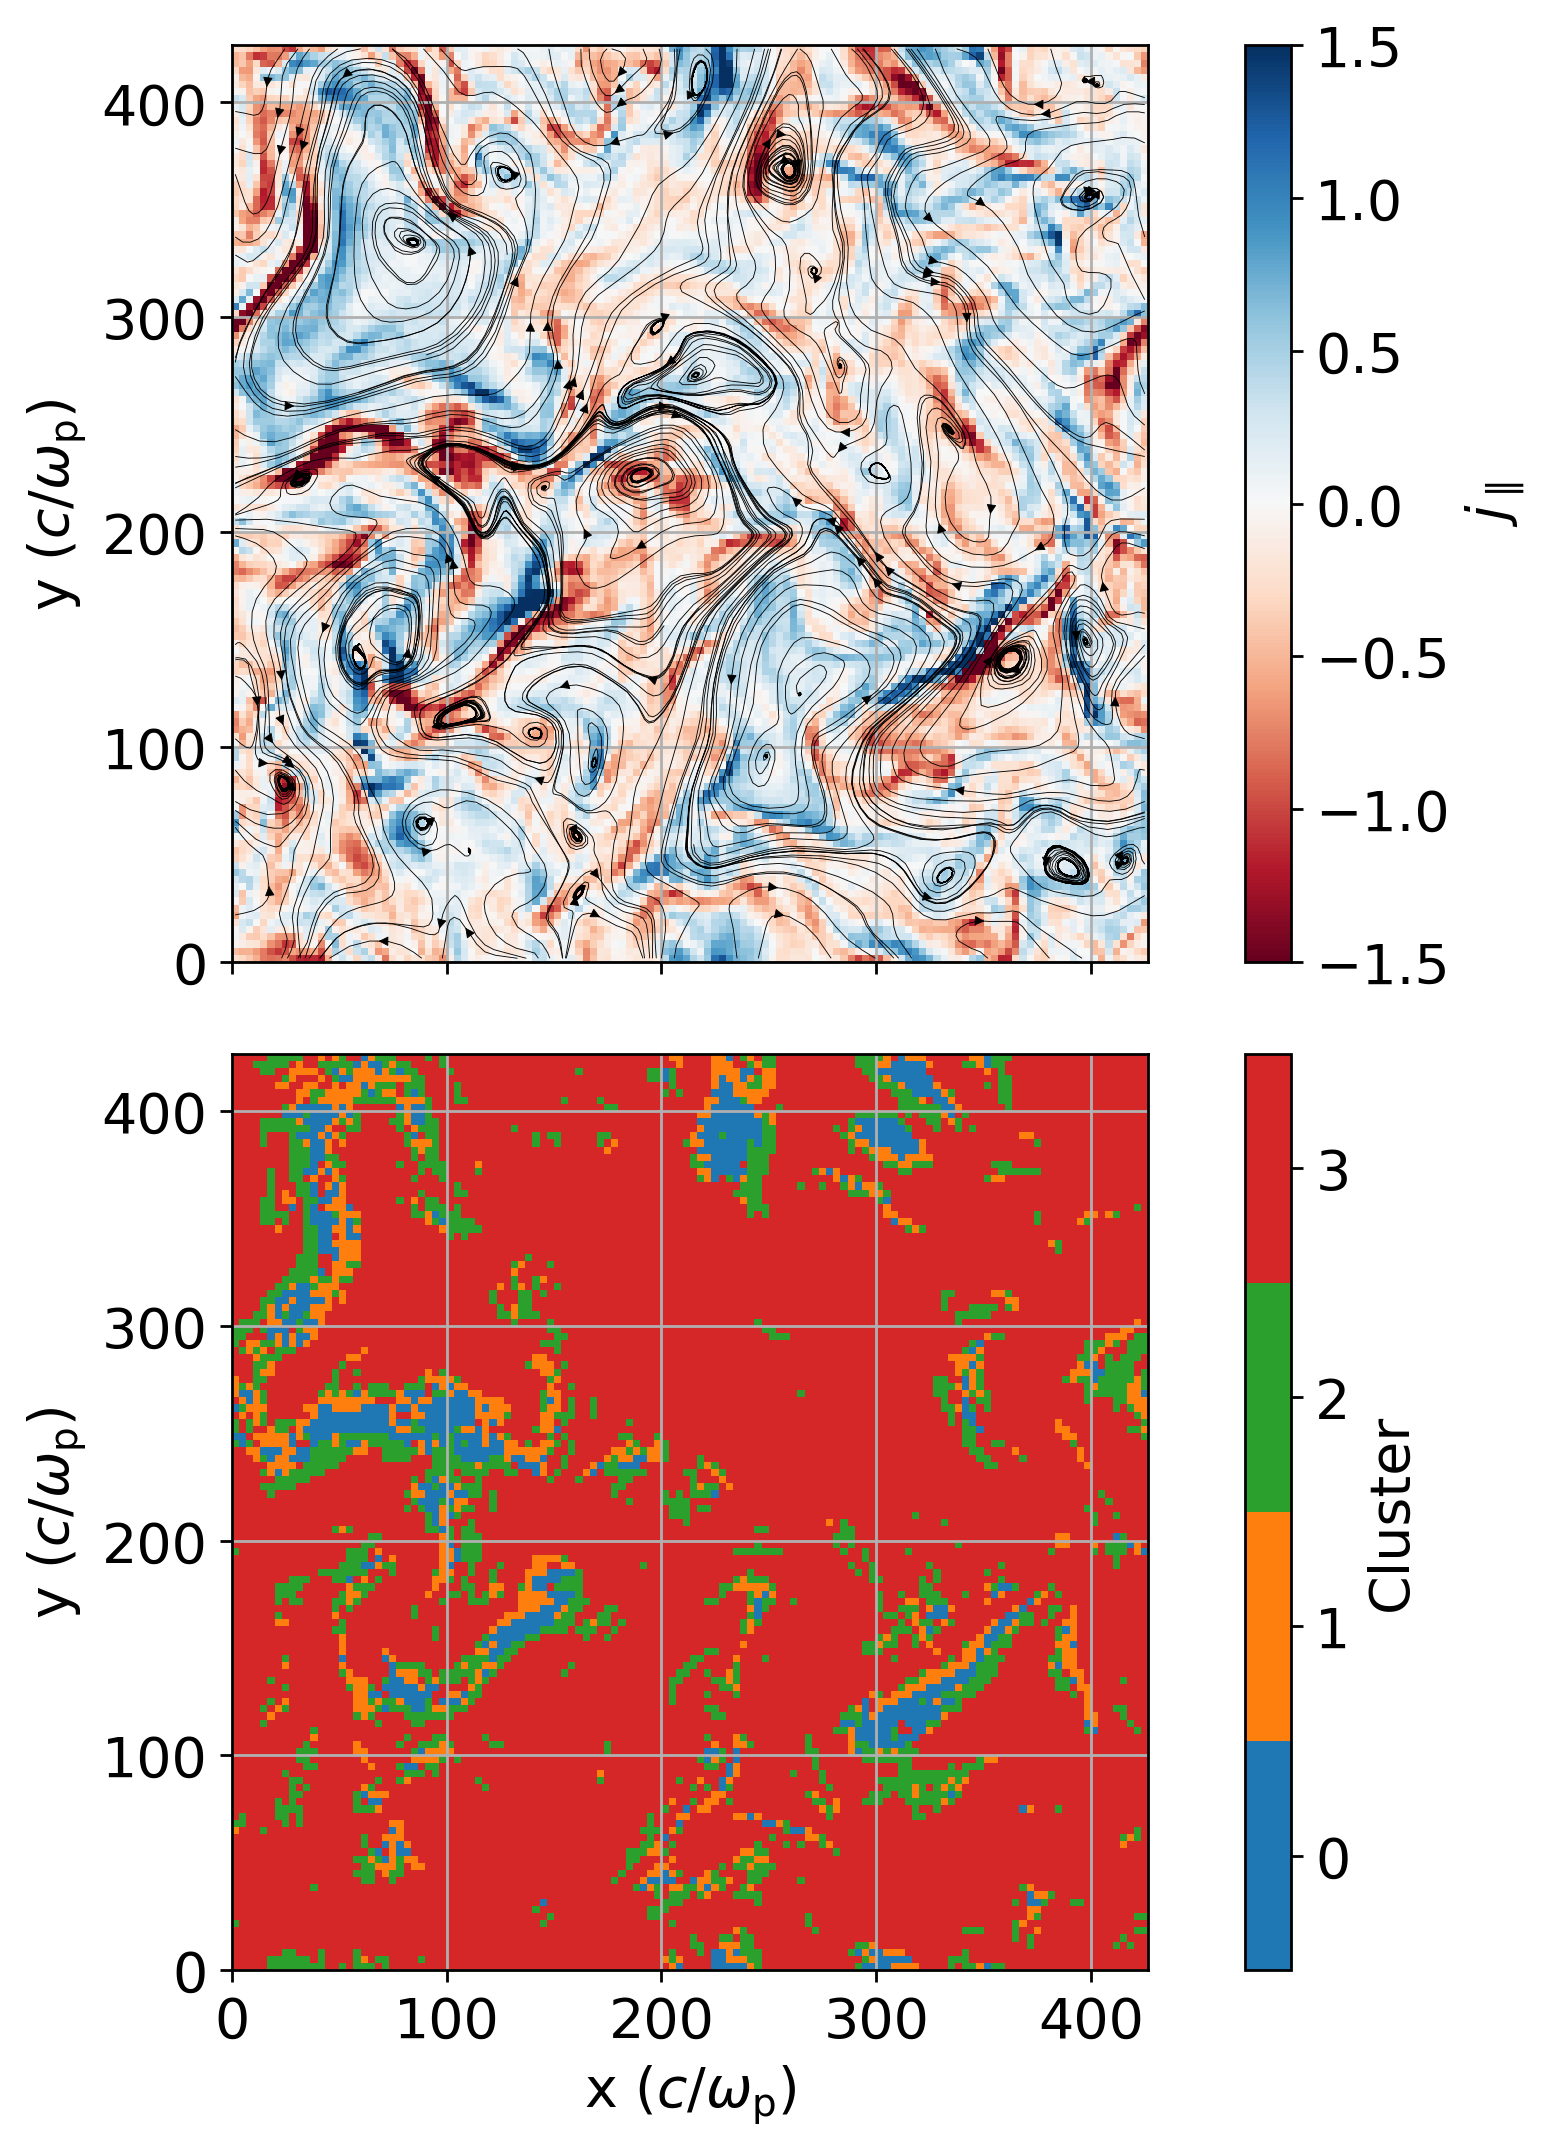

In [ ]:
sce_clusters_transformed = sce_clusters.reshape((128,128,128))

plt.rcParams.update({'font.size': 16})

slice_numbers = [27]

for slice_number in slice_numbers:
    fig, ax = plt.subplots(2, 1, figsize=(10, 10), dpi=250, sharex=True)
    fig.subplots_adjust(hspace=0.1)

    jmag_plot = ax[0].pcolormesh(j_par[slice_number], cmap='RdBu', clim=[-1.5,1.5], rasterized=True)
    fig.colorbar(jmag_plot, ax=ax[0], fraction=0.042, pad=0.05, label=r'$j_{\parallel}$', ticks=[-1.5, -1, -0.5, 0, 0.5, 1, 1.5], location="right")
    # ax[0].contour(np.arange(0, nx)+0.5, np.arange(0, ny)+0.5, j_par[slice_number,:,:], levels=[-2.*j_par_rms,2.*j_par_rms], colors='green', linewidths=1, linestyles='solid')
    ax[0].streamplot(np.arange(0, nx)+0.5, np.arange(0, ny)+0.5, bx[slice_number], by[slice_number], color='black', linewidth=0.25, broken_streamlines=False, density=1., integration_direction='both', arrowstyle='-|>', arrowsize=0.6, )
    # fig.colorbar(eperp_plot, ax=ax[0], fraction=0.042, pad=0.04, label=r'$E_{\perp}$', ticks=[0, 0.1, 0.2, 0.3])
    ax[0].set_aspect('equal', adjustable='box')
    ax[0].grid()
    # ax[0].set_xticks(np.arange(0, 128, 30), np.arange(0, 128*dx, 30*dx, dtype=int))
    ax[0].set_yticks(np.arange(0, 128, 30), np.arange(0, 128*dx, 30*dx, dtype=int))
    # ax[0].set_xlabel(r'x ($c/\omega_p$)')
    ax[0].set_ylabel(r'y ($c/\omega_{\rm p}$)')
    # ax[0].set_title(f'z = {slice_number*dx:.0f} '+ r'$c/\omega_{\rm p}$')

    cluster_plot = ax[1].pcolormesh(sce_clusters_transformed[slice_number], cmap='tab10', clim=[0,10], rasterized=True)
    cbar = fig.colorbar(cluster_plot, ax=ax[1], fraction=0.042, pad=0.05, label='Cluster', ticks=np.arange(0, len(signal_cutoff)+1)+0.5, boundaries=np.arange(0, len(signal_cutoff)+2), location="right")
    cbar.ax.set_yticklabels(np.arange(0, len(signal_cutoff)+1))
    # ax[1].contour(np.arange(0, nx)+0.5, np.arange(0, ny)+0.5, j_par[slice_number,:,:], levels=[-2.*j_par_rms,2.*j_par_rms], colors=['red','blue'], linewidths=1, linestyles='solid')
    # ax[1].streamplot(np.arange(0, nx)+0.5, np.arange(0, ny)+0.5, bx[slice_number], by[slice_number], color='black', linewidth=0.25, broken_streamlines=False, density=1, integration_direction='both', arrowstyle='-|>', arrowsize=0.6, )
    ax[1].set_aspect('equal', adjustable='box')
    ax[1].grid()
    ax[1].set_xticks(np.arange(0, 128, 30), np.arange(0, 128*dx, 30*dx, dtype=int))
    ax[1].set_yticks(np.arange(0, 128, 30), np.arange(0, 128*dx, 30*dx, dtype=int))
    ax[1].set_xlabel(r'x ($c/\omega_{\rm p}$)')
    ax[1].set_ylabel(r'y ($c/\omega_{\rm p}$)')

    plt.show()

## Optional - Generate different sets of features

**Under Construction**